# Churn Prediction Multiple Input Model - 1D CNN with LSTM  

Last Updated: December 11, 2018

In [148]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import pyodbc
import datetime
from sklearn import preprocessing
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn import preprocessing
import os
from os.path import join, dirname
from os.path import dirname, join
from tqdm import tqdm_notebook
import pandas as pd
from pandas import pivot
from pandas import tools
import numpy as np
import cv2
import re
import io
import sys 
import pip
import csv
from sklearn.model_selection import train_test_split
import glob
import random
import warnings
from pandas import DataFrame   
import pickle
import cloudpickle
import azureml
import string
from scipy import stats
import pyparsing
import tempfile  
import logging
import graphviz
#Keras and NLP Packages
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer     
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers.core import Dropout
from keras.layers import LSTM
from keras.layers import Dense, Input, Flatten 
from keras.layers import Conv1D, MaxPooling1D, Embedding 
from keras.models import Model 
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.applications import imagenet_utils
from keras.layers import Embedding
from keras.utils.np_utils import to_categorical
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
import keras.backend as K
import gensim
from gensim.models import Phrases, phrases
from gensim.models.phrases import Phraser
from gensim.models import Word2Vec as wv
import nltk
from gensim import corpora, models, similarities
from __future__ import division
import numpy as np
import nltk
from nltk.corpus import stopwords
from azure.storage.blob import BlockBlobService
from textgenrnn import textgenrnn

## 0: Setting Up

In [149]:
PATH = 'D://MAFData//'
PATH_OUT =  'D://MAFData//'
PATH_GLOVE = 'C://MAFVentures//glove//'
PATH_MODEL_DELETE = 'D://MAFData//'
PATH_MODEL = 'D://MAFData//'

In [150]:
#os.chdir('D://MAFData')
#base_dir = 'D://MAFData'
#print(base_dir)
#os.getcwd()
np.random.seed(2032)

## 1: Getting Data Ready

### Read in Categorical Data
- input file: `Categorical_dataframe.csv`
- output var: `df1`


** NOTE: `df1` duplicated with `Text_Cats_TimeSteps_df`** !!!!!

In [151]:
dtypes = {'Sequence': str, 'ATTRITION_FLAG': str}

Text_Cats_TimeSteps_df = pd.read_csv(PATH + 'Categorical_dataframe.csv',sep=',',encoding='utf-8', header = 0) 

Text_Cats_TimeSteps_df = Text_Cats_TimeSteps_df[[
 'Account_Number',
 'MISDATE',
 'Incident_Category',
 'Incident_Type',
 'Incident_Cat_Sequence_Daily',
 'Incident_Type_Sequence_Daily',
 ]]

In [152]:
Text_Cats_TimeSteps_df.shape
list(Text_Cats_TimeSteps_df.columns)
Text_Cats_TimeSteps_df.head(1)

(9408644, 6)

['Account_Number',
 'MISDATE',
 'Incident_Category',
 'Incident_Type',
 'Incident_Cat_Sequence_Daily',
 'Incident_Type_Sequence_Daily']

,Account_Number,MISDATE,Incident_Category,Incident_Type,Incident_Cat_Sequence_Daily,Incident_Type_Sequence_Daily
0,MAFF_ACCT_0000002125,2017-09-07,Transaction Enquiry,Account Enquiry,Transaction Enquiry,Account Enquiry


### Labels
- input file: `Account_Churn_Labels.csv`
- output var: `Labels`

In [153]:
Labels = pd.read_csv(PATH + 'Account_Churn_Labels.csv',sep=',',encoding='utf-8')
Labels.drop(columns=['Unnamed: 0'], inplace=True)
Labels.shape
Labels.head(1)

(81109, 2)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000002125,OPEN


### Merge Categorical Data with Labels
- input df: `Text_Cats_TimeSteps_df`, `Labels`
- ouput df: `Text_Cats_TimeSteps_df`

In [154]:
Text_Cats_TimeSteps_df = pd.merge(Text_Cats_TimeSteps_df, Labels,
                                  how='left', left_on='Account_Number', right_on='Account_Number')

In [155]:

list(Text_Cats_TimeSteps_df.columns)

['Account_Number',
 'MISDATE',
 'Incident_Category',
 'Incident_Type',
 'Incident_Cat_Sequence_Daily',
 'Incident_Type_Sequence_Daily',
 'ATTRITION_FLAG']

## 2:  Prepare Sequence by Account Data for for 1D CNN
### Prepare Categorical Data
- input df: `Text_Cats_TimeSteps_df`
- output df: `df_text`

** NOTE: `df1` or `df_text` may be redundant ** 

In [156]:
df_text = Text_Cats_TimeSteps_df
df_text['MISDATE'] = pd.to_datetime(df_text['MISDATE'], format='%Y-%m-%d')

df_text.shape
df_text.head(1)
df_text.dtypes

(9408644, 7)

,Account_Number,MISDATE,Incident_Category,Incident_Type,Incident_Cat_Sequence_Daily,Incident_Type_Sequence_Daily,ATTRITION_FLAG
0,MAFF_ACCT_0000002125,2017-09-07,Transaction Enquiry,Account Enquiry,Transaction Enquiry,Account Enquiry,OPEN


Account_Number                          object
MISDATE                         datetime64[ns]
Incident_Category                       object
Incident_Type                           object
Incident_Cat_Sequence_Daily             object
Incident_Type_Sequence_Daily            object
ATTRITION_FLAG                          object
dtype: object

In [157]:
len(df_text)/116

81109.0

### Concatanate `Incident_Category` into one row per account `Incident_Cat_Sequence_Daily`
- input df: `df_text`
- output df: `df_text_cleaned`

In [158]:
df_text = df_text.sort_values(['Account_Number','MISDATE'], ascending=[True, False])
df_text = df_text.reset_index(drop=True)

In [159]:
# Aggregate longer sequences of multiple incident categories per account into its own variable.
accounts = df_text.groupby(['Account_Number']).head(1)
accounts = pd.DataFrame(accounts)
accounts = accounts.reset_index(drop=True)
accounts.shape

accounts = pd.DataFrame(accounts['Account_Number'])
accounts.head(1)

(81109, 7)

,Account_Number
0,MAFF_ACCT_0000002125


In [160]:
df_text_cleaned = df_text.groupby(['Account_Number'])['Incident_Category'].agg(lambda col: ' _ '.join(col))

# convert from Series to DataFrame
df_text_cleaned = pd.DataFrame(df_text_cleaned)
df_text_cleaned = df_text_cleaned.reset_index(drop=True)
df_text_cleaned.columns = ['Incident_Cat_Sequence']
df_text_cleaned.shape

(81109, 1)

In [161]:
# Aggregate longer sequences of multiple incident types per account into its own variable.
df_text_cleaned2 = df_text.groupby(['Account_Number'])['Incident_Type'].agg(lambda col: ' _ '.join(col))

# convert from Series to DataFrame
df_text_cleaned2 = pd.DataFrame(df_text_cleaned2)
df_text_cleaned2 = df_text_cleaned2.reset_index(drop=True)
df_text_cleaned2.columns = ['Incident_Type_Sequence']
df_text_cleaned2.shape

(81109, 1)

In [162]:
df_sequences = pd.concat([accounts.reset_index(), df_text_cleaned], axis=1)
df_sequences = pd.concat([df_sequences.reset_index(), df_text_cleaned2], axis=1)
df_sequences = df_sequences.reset_index(drop=True)

df_sequences.shape
df_sequences.head(1)
df_sequences.columns

(81109, 5)

,level_0,index,Account_Number,Incident_Cat_Sequence,Incident_Type_Sequence
0,0,0,MAFF_ACCT_0000002125,Transaction Enquiry _ None _ None _ None _ Non...,Account Enquiry _ None _ None _ None _ None _ ...


Index(['level_0', 'index', 'Account_Number', 'Incident_Cat_Sequence',
       'Incident_Type_Sequence'],
      dtype='object')

In [163]:
del df_sequences['index']
del df_sequences['level_0']
df_sequences.head(3)

,Account_Number,Incident_Cat_Sequence,Incident_Type_Sequence
0,MAFF_ACCT_0000002125,Transaction Enquiry _ None _ None _ None _ Non...,Account Enquiry _ None _ None _ None _ None _ ...
1,MAFF_ACCT_0000002171,None _ None _ None _ None _ None _ None _ None...,None _ None _ None _ None _ None _ None _ None...
2,MAFF_ACCT_0000002222,None _ None _ None _ None _ None _ None _ None...,None _ None _ None _ None _ None _ None _ None...


In [164]:
df_sequences['Incident_Cat_Sequence'] = df_sequences['Incident_Cat_Sequence'].str.replace(' _ ',' ')
df_sequences['Incident_Type_Sequence'] = df_sequences['Incident_Type_Sequence'].str.replace(' _ ',' ')
df_sequences.shape
df_sequences.head(2)

(81109, 3)

,Account_Number,Incident_Cat_Sequence,Incident_Type_Sequence
0,MAFF_ACCT_0000002125,Transaction Enquiry None None None None None N...,Account Enquiry None None None None None None ...
1,MAFF_ACCT_0000002171,None None None None None None None None None N...,None None None None None None None None None N...


In [165]:
#Most clean up already done in pre-processing script in a jupyter notebook.
df_sequences['Incident_Cat_Sequence'] = df_sequences['Incident_Cat_Sequence'].astype('str')
df_sequences['Incident_Type_Sequence'] = df_sequences['Incident_Type_Sequence'].astype('str')
df_sequences['Incident_Cat_Sequence'] = df_sequences['Incident_Cat_Sequence'].str.lower()
df_sequences['Incident_Type_Sequence'] = df_sequences['Incident_Type_Sequence'].str.lower()

df_sequences["Sequence"] = df_sequences["Incident_Cat_Sequence"] + " " + df_sequences["Incident_Type_Sequence"]
df_sequences["Sequence"] = df_sequences["Account_Number"] + " " + df_sequences["Sequence"]

df_sequences= df_sequences[['Account_Number','Sequence']]
df_sequences['Sequence'].apply(len).max()

1808

In [166]:
df_sequences.shape
list(df_sequences.columns)

df_sequences.dtypes


(81109, 2)

['Account_Number', 'Sequence']

Account_Number    object
Sequence          object
dtype: object

### Merge `Labels` with `df_sequences`
- input df: `Labels`, `df_sequences`
- output df: `df_Joined`

In [167]:
df_Joined = pd.merge(df_sequences, Labels,  
                     how = 'left', 
                     left_on = 'Account_Number', 
                     right_on = 'Account_Number')

In [168]:
df_Joined.shape
list(df_Joined.columns)
df_Joined = df_Joined.reset_index(drop=True)


(81109, 3)

['Account_Number', 'Sequence', 'ATTRITION_FLAG']

#### Counts for `OPEN` and `VOLUNTARY`

In [169]:
df_Joined['ATTRITION_FLAG'].value_counts()
df_Joined.shape

OPEN         74267
VOLUNTARY     6842
Name: ATTRITION_FLAG, dtype: int64

(81109, 3)

### Cleantext function to make sequences ready for word embeddings 
- input : column operation only
- output : column operation only

In [170]:
def clean_text(row):
    text = str(row['Sequence'])

    # Remove newline characters
    cleantext = text.replace('-', '')
    cleantext = cleantext.replace('carrefour', 'carrefour ')
    cleantext = cleantext.replace('tactical', 'tactical ')
    cleantext = cleantext.replace('received', 'received ')
    cleantext = cleantext.replace('merchant', 'merchant ')
    cleantext = cleantext.replace('lifestyle', ' lifestyle ')
    cleantext = cleantext.replace('promo', ' promotion ')
    cleantext = cleantext.replace('easy', ' easy ')
    cleantext = cleantext.replace('payment', ' payment ') 
    #cleantext = cleantext.replace('transact', ' transact ') 
    cleantext = cleantext.replace('acct', ' account ') 
    cleantext = cleantext.replace('enquiries', ' enquiries ') 
    cleantext = cleantext.replace('tactical', ' tactical ') 

    # Convert HTML punctuation chaaracters
    cleantext = cleantext.replace('.', '')

    #remove punctuation
    punctpattern = re.compile('[%s]' % re.escape(string.punctuation))
    cleanttext = re.sub(punctpattern,'', cleantext)
    cleantext = cleantext.replace("\\", "") 
    cleantext = cleantext.replace("/", "")
    cleantext = re.sub("[^a-zA-Z' ]+", '', cleantext)

    #remove single letter word
    cleantext = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', cleantext) 

    #remove non alpha characters and specific noise
    cleantext = re.sub(r'\d+', '',cleantext)
    cleantext = re.sub(r'^b','',cleantext)
    #cleantext = re.sub(r'[^\w]',' ',cleantext)

    #remove specific noise
    cleantext = cleantext.translate(str.maketrans({'‘':' ','’':' '}))
    cleantext = cleantext.translate(str.maketrans({',':' ',',':' '}))
    cleantext = cleantext.translate(str.maketrans({'"':' ','%':' '}))
    
    # Remove extra spaces
    cleantext = re.sub('\s+', ' ', cleantext).strip()

    return cleantext

In [171]:
#apply regex fixes to the input text column
df_Joined1 = df_Joined
df_Joined1['CleanText'] = df_Joined1.apply(clean_text, axis=1)
del df_Joined1['Sequence']
df_Joined1.head(2)
df_Joined1.shape

,Account_Number,ATTRITION_FLAG,CleanText
0,MAFF_ACCT_0000002125,OPEN,MAFFACCT transaction enquiry none none none no...
1,MAFF_ACCT_0000002171,OPEN,MAFFACCT none none none none none none none no...


(81109, 3)

In [172]:
df_Joined = df_Joined1
justcleandocs = pd.DataFrame(df_Joined)

### Saving intermediate file


In [173]:
#save a cleaned copy to inspect
justcleandocs.to_csv('cleaned_text.tsv', sep='\t', encoding='utf-8')
print(justcleandocs.shape)
justcleandocs.head(2)

(81109, 3)


,Account_Number,ATTRITION_FLAG,CleanText
0,MAFF_ACCT_0000002125,OPEN,MAFFACCT transaction enquiry none none none no...
1,MAFF_ACCT_0000002171,OPEN,MAFFACCT none none none none none none none no...


### Seperate Labels from Sequences
- input df: `df_Joined`
- output df: `Text_Sequence_df`, `Labels`


In [174]:
df_Joined['ATTRITION_FLAG'].value_counts()

OPEN         74267
VOLUNTARY     6842
Name: ATTRITION_FLAG, dtype: int64

In [175]:
Labels = df_Joined[['Account_Number','ATTRITION_FLAG']]
Text_Sequence_df = df_Joined[['Account_Number','CleanText']]

Labels_backup = Labels

In [176]:
Labels.columns
Labels.shape
Labels.head(1)

Text_Sequence_df.columns
Text_Sequence_df.shape
Text_Sequence_df.head(1)

Index(['Account_Number', 'ATTRITION_FLAG'], dtype='object')

(81109, 2)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000002125,OPEN


Index(['Account_Number', 'CleanText'], dtype='object')

(81109, 2)

,Account_Number,CleanText
0,MAFF_ACCT_0000002125,MAFFACCT transaction enquiry none none none no...


In [177]:
Text_Sequence_df.shape
list(Text_Sequence_df.columns)

(81109, 2)

['Account_Number', 'CleanText']

### Create Tokenized Word Index for Later Use

file in: Text_Sequence_df['CleanText']
file out: word_index

In [178]:
np.set_printoptions(threshold=np.nan)

In [179]:
#Tokenize all samples
# Here we tokenize our source data
MAX_SEQUENCE_LENGTH = 1500
MAX_NB_WORDS = 400000
EMBEDDING_DIM = 300

In [180]:
# Taking on the CleatnText Column
justcleandocs = Text_Sequence_df[['CleanText']]
justcleandocs.head()
justcleandocs.shape

,CleanText
0,MAFFACCT transaction enquiry none none none no...
1,MAFFACCT none none none none none none none no...
2,MAFFACCT none none none none none none none no...
3,MAFFACCT none none none none none none none no...
4,MAFFACCT none none billed finance charge none ...


(81109, 1)

In [181]:
#convert text format
justcleandocslist  = justcleandocs.values.ravel()
justcleandocslist.shape

(81109,)

In [182]:
#check justcleandocslist
justcleandocslist[0]
type(justcleandocslist)

'MAFFACCT transaction enquiry none none none none none none none none none none none none none marketing campaign none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none najm lifestyle none none none none none none none none none none none none none none none none none none none none none none none none transaction enquiry none none none none none none transaction enquiry none none none none none none none none none none none none none none none none none none none none none account enquiry none none none none none none none none none none none none none additional features on card none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none none no

numpy.ndarray

In [183]:
#tokenize the text
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(justcleandocslist) #tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(justcleandocslist) #sequences = tokenizer.texts_to_sequences(texts)

In [184]:
word_index = tokenizer.word_index #word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))


Found 294 unique tokens


In [185]:
#Pad sequences so that they all have the same length in a batch of input data 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre')
sequences = None
texts = None

In [186]:
data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [187]:
word_index

{'ac': 287,
 'accepted': 176,
 'accident': 47,
 'account': 8,
 'acli': 33,
 'activation': 92,
 'additional': 6,
 'address': 57,
 'adjustment': 209,
 'advance': 243,
 'agent': 186,
 'already': 266,
 'amf': 194,
 'amount': 19,
 'and': 185,
 'annual': 136,
 'application': 149,
 'applied': 277,
 'at': 49,
 'atm': 250,
 'back': 253,
 'balance': 155,
 'banking': 200,
 'benefits': 288,
 'billed': 22,
 'billing': 104,
 'block': 135,
 'booking': 162,
 'booz': 188,
 'box': 290,
 'bt': 58,
 'btlopepp': 132,
 'buy': 61,
 'by': 11,
 'calculation': 111,
 'call': 60,
 'campaign': 10,
 'campaigns': 254,
 'cancellation': 110,
 'cancellations': 75,
 'cancelled': 294,
 'cannot': 213,
 'captured': 251,
 'card': 4,
 'cards': 221,
 'carrefour': 41,
 'cases': 12,
 'cash': 152,
 'cashback': 145,
 'cdm': 124,
 'cec': 126,
 'center': 201,
 'change': 131,
 'charge': 138,
 'charges': 88,
 'cheque': 27,
 'chip': 156,
 'claim': 203,
 'clarification': 103,
 'clearance': 291,
 'cli': 282,
 'closed': 249,
 'cm': 48,
 

## 3: Create  `Train`, `Val`, `Test` index and dataset  

### Import Master Sampling Index to Create Train, Val and Test Sets
- input file: `index_train_attrits.csv`, `index_val_attrits`, `index_val_opens.csv`, `index_train_opens.csv`
- output df: `index_train_attrits`, `index_val_attrits`, `index_val_opens`, `index_train_opens` 

In [188]:
#Sampling Index

dtypes = {'Account_Number': str}
index_train_attrits = pd.read_csv(PATH + 'index_train_attrits.csv',sep=',',encoding='utf-8', header = 0) #, dtype = dtypes)
index_train_attrits = pd.DataFrame(index_train_attrits[['Account_Number']])

index_train_opens = pd.read_csv(PATH + 'index_train_opens.csv',sep=',',encoding='utf-8', header = 0) #, dtype = dtypes)
index_train_opens = pd.DataFrame(index_train_opens[['Account_Number']])

index_val_attrits = pd.read_csv(PATH + 'index_val_attrits.csv',sep=',',encoding='utf-8', header = 0) #, dtype = dtypes)
index_val_attrits = pd.DataFrame(index_val_attrits[['Account_Number']])

index_val_opens = pd.read_csv(PATH + 'index_val_opens.csv',sep=',',encoding='utf-8', header = 0) #, dtype = dtypes)
index_val_opens = pd.DataFrame(index_val_opens[['Account_Number']])

In [189]:
#Assemble and shuffle rows
index_train= index_train_opens.append(index_train_attrits, ignore_index=True)
index_train = index_train.reset_index(drop=True)
index_train = index_train.sample(frac=1).reset_index(drop=True)
index_train.shape

index_val= index_val_opens.append(index_val_attrits, ignore_index=True)
index_val = index_val.reset_index(drop=True)
index_val = index_val.sample(frac=1).reset_index(drop=True)
index_val.shape

(54996, 1)

(25977, 1)

### Create Data Samples for Train and Validation

In [190]:
#create index length of the sequence data column
Text_Sequence_df['num']=Text_Sequence_df.reset_index().index
Text_Sequence_df.reset_index(drop=True, inplace=True)

Text_Sequence_df.head(2)
indices = Text_Sequence_df['num']
indices.head()
indices.shape

,Account_Number,CleanText,num
0,MAFF_ACCT_0000002125,MAFFACCT transaction enquiry none none none no...,0
1,MAFF_ACCT_0000002171,MAFFACCT none none none none none none none no...,1


0    0
1    1
2    2
3    3
4    4
Name: num, dtype: int64

(81109,)

In [191]:
Labels.head(1)
Text_Sequence_df.head(1)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000002125,OPEN


,Account_Number,CleanText,num
0,MAFF_ACCT_0000002125,MAFFACCT transaction enquiry none none none no...,0


In [192]:
#Split data into validation and train sets based on master sample index, merge to text sequence data.
data_train = pd.merge(index_train, Text_Sequence_df, how='inner', left_on=['Account_Number'],  right_on = ['Account_Number'])
data_train.shape
data_train.head(2)

Labels_train = pd.merge(index_train, Labels, how='inner', left_on=['Account_Number'],  right_on = ['Account_Number'])
Labels_train.shape
Labels_train.head(2)

data_val = pd.merge(index_val, Text_Sequence_df, how='inner', left_on=['Account_Number'], right_on = ['Account_Number'])
data_val.shape
data_val.head(2)

Labels_val = pd.merge(index_val, Labels, how='inner', left_on=['Account_Number'],  right_on = ['Account_Number'])
Labels_val.shape
Labels_val.head(2)

Labels_train_df = Labels_train
Labels_val_df = Labels_val
Labels_train_df['ATTRITION_FLAG'].value_counts()

(42700, 3)

,Account_Number,CleanText,num
0,MAFF_ACCT_0000054355,MAFFACCT none none none none none none none no...,33589
1,MAFF_ACCT_0000061220,MAFFACCT none none none none none none none no...,39390


(42700, 2)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000054355,OPEN
1,MAFF_ACCT_0000061220,OPEN


(21498, 3)

,Account_Number,CleanText,num
0,MAFF_ACCT_0000171653,MAFFACCT none none none none none none none no...,61527
1,MAFF_ACCT_0000052384,MAFFACCT none none none none none none none no...,31980


(21498, 2)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000171653,OPEN
1,MAFF_ACCT_0000052384,VOLUNTARY


OPEN         38582
VOLUNTARY     4118
Name: ATTRITION_FLAG, dtype: int64

### Create numpy array of index values
- input df: `data_train['num']`, `data_val['num']`
- output np.ndarray : `train_sampling_index1`, `val_sampling_index1`

### Create `X_Train`, `X_Val` numpy arrays for 1DCNN

In [193]:
Train_index = data_train['num']
Val_index = data_val['num']
Train_index = Train_index.values
Val_index = Val_index.values

type(Train_index)
type(Val_index)


numpy.ndarray

numpy.ndarray

In [194]:
data_train = data[Train_index]
data_val = data[Val_index]
X_train = data_train
X_val = data_val
type(X_train)
type(X_val)
X_train.shape
X_val.shape

numpy.ndarray

numpy.ndarray

(42700, 1500)

(21498, 1500)

### Create `y_Train`, `y_Val` categorical numpy arrays for labels

In [195]:
Labels_val.shape
type(Labels_val)

Labels_train.shape
type(Labels_train)

Labels_train['ATTRITION_FLAG'].value_counts()

(21498, 2)

pandas.core.frame.DataFrame

(42700, 2)

pandas.core.frame.DataFrame

OPEN         38582
VOLUNTARY     4118
Name: ATTRITION_FLAG, dtype: int64

### Convert Attrition Flag to Integer

In [196]:
Labels_train.head(2)
Labels_train['ATTRITION_FLAG'] = np.where(Labels_train['ATTRITION_FLAG']=='OPEN', 0, 1)
Labels_val['ATTRITION_FLAG'] = np.where(Labels_val['ATTRITION_FLAG']=='OPEN', 0, 1)

Labels_train['ATTRITION_FLAG'].value_counts()

Labels_train=Labels_train[['ATTRITION_FLAG']]
Labels_val=Labels_val[['ATTRITION_FLAG']]

#Convert Labels to Categorical
y_train  = Labels_train.values
y_val  = Labels_val.values

y_train = to_categorical(np.asarray(y_train))
y_val = to_categorical(np.asarray(y_val))

y_train.shape
y_val.shape

labels_index = {}
labels_index =  {0:0,1:1}
print('labels_index', labels_index)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000054355,OPEN
1,MAFF_ACCT_0000061220,OPEN


0    38582
1     4118
Name: ATTRITION_FLAG, dtype: int64

(42700, 2)

(21498, 2)

labels_index {0: 0, 1: 1}


### Load Word Embeddings

In [197]:
#load in word vectors from glove reference global English data set
# https://nlp.stanford.edu/projects/glove/

embeddings_index = {}
words = pd.read_table(PATH_GLOVE + 'glove.6B.300d.txt', sep=" ", header=None, quoting=csv.QUOTE_NONE)

In [198]:
#words.head(5)
print('shape of glove model', words.shape)

shape of glove model (400000, 301)


In [199]:
wordkeys=words.iloc[:,0]
print('wordkeys type of file', type(wordkeys))
words2 = words.rename(columns={ words.columns[0]: "words" })

wordkeys type of file <class 'pandas.core.series.Series'>


### Build Embedding Index for our Word Index from Glove Embeddings

In [200]:
embeddings_index = words2.set_index('words').T.to_dict('list')
print('Found {} word vectors.'.format(len(embeddings_index)))

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  if __name__ == '__main__':


Found 399998 word vectors.


In [201]:
#################################
#Build the embedding matrix
#################################

print('Building Embedding Matrix...')
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Embedding Matrix Built')

Building Embedding Matrix...
Embedding Matrix Built


### Write out a Copy of Data and Labels for Multi-Input Model

### `X_val_cnn`, `y_val_cnn`, `X_train_cnn`, `y_train_cnn`

In [202]:
X_val_cnn = X_val
y_val_cnn = y_val
X_train_cnn = X_train
y_train_cnn = y_train

In [203]:
X_val_cnn.shape
y_val_cnn.shape
X_train_cnn.shape
y_train_cnn.shape

(21498, 1500)

(21498, 2)

(42700, 1500)

(42700, 2)

### Create class weighting

### Saving data to files


In [204]:
#save a copy of 1DCNN Sequence Data to the Local Drive
os.chdir('D://MAFData')
         
np.savetxt('Source__X_val_1DCNN.tsv', X_val_cnn, delimiter='\t',  encoding='utf-8')
np.savetxt('Source__X_train_1DCNN.tsv', X_train_cnn, delimiter='\t',  encoding='utf-8')
np.savetxt('Source__y_val.tsv', X_val_cnn, delimiter='\t',  encoding='utf-8')
np.savetxt('Source__y_train.tsv', X_train_cnn, delimiter='\t',  encoding='utf-8')



## 4. Build Models

### 4.1 1D CNN

### Design a 1D Convolutional Neural Net

Train 1D Convnet with global maxpooling
Shape of training data sample tensor:  (42700, 1500)
Shape of training label tensor:  (42700, 2)


TensorShape([Dimension(None), Dimension(1500)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1500)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1500, 300)         88500     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1493, 128)         307328    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 298, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 298, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 283, 128)          262272    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 56, 128)           0         
__________

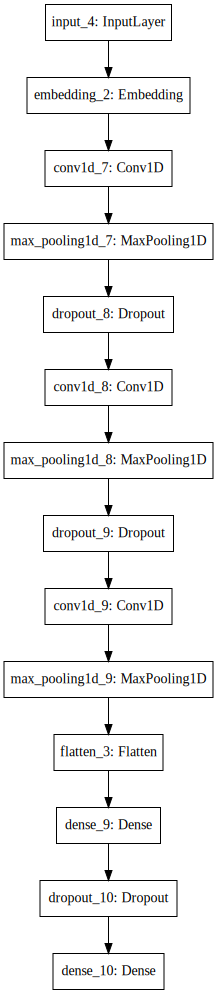

In [205]:
#Set Dropout Rates
DROPOUT_RATE = 0.5
INNERLAYER_DROPOUT_RATE = 0.2

print('Train 1D Convnet with global maxpooling')
print('Shape of training data sample tensor: ', X_train_cnn.shape)
print('Shape of training label tensor: ', y_train_cnn.shape)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
sequence_input.shape

embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 8, activation='relu', kernel_initializer='glorot_uniform',use_bias=True)(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(INNERLAYER_DROPOUT_RATE)(x)

x = Conv1D(128, 16, activation='relu', kernel_initializer='glorot_uniform',use_bias=True)(x)
x = MaxPooling1D(5)(x)
x = Dropout(INNERLAYER_DROPOUT_RATE)(x)

x = Conv1D(128, 16, activation='relu', kernel_initializer='glorot_uniform',use_bias=True)(x)
x = MaxPooling1D(35)(x)  # global max pooling

x = Flatten()(x) 

x = Dense(120,use_bias=True,kernel_initializer='glorot_uniform')(x) 
x = Dropout(DROPOUT_RATE)(x)

preds = Dense(len(labels_index),activation='sigmoid')(x) #no initialization in output layer
model = Model(sequence_input, preds)

model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Compile the Model

In [206]:
from keras.callbacks import History 

LEARNING_RATE = .00001 

adam = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipnorm = .5)
rmsprop = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=1e-08, decay=0.00, clipnorm = .5)

model.compile(loss='binary_crossentropy', optimizer= adam, metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

### Fit 1D CNN Model

In [207]:
cnn_model_path = PATH_MODEL_DELETE + 'Multiple_Input_Model_Best_Run_1DCNN_Nov5.h5'
# Define global variables 

BATCH_SIZE = 800
class_weight = {0 : 1., 
                1: 10}

history = History()

history = model.fit(X_train_cnn, y_train_cnn, batch_size=BATCH_SIZE, epochs=2, verbose=2, 
                    validation_split=0, 
                    validation_data=(X_val_cnn, y_val_cnn),  
                    class_weight = class_weight, 
                    

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='min'),
             keras.callbacks.ModelCheckpoint(cnn_model_path,monitor='val_loss', save_best_only=True, mode='min')])

print(history.history.keys())

Train on 42700 samples, validate on 21498 samples
Epoch 1/2
 - 93s - loss: 1.2966 - acc: 0.3312 - val_loss: 0.7066 - val_acc: 0.1285
Epoch 2/2
 - 92s - loss: 1.2928 - acc: 0.3310 - val_loss: 0.7038 - val_acc: 0.2248
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

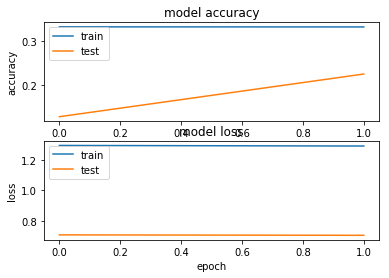

In [208]:
InteractiveShell.ast_node_interactivity = "none"

import matplotlib.pyplot as plt  
plt.figure(1)  

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

## 4.2 Build RNN Model on Numerical Sequential Dataframe

### Read in Numerical Data Source

In [209]:
with open(PATH + 'df_Numerical.pkl', 'rb') as f:
    Numerical_df = pickle.load(f)
    
Numerical_df.shape
Numerical_df.head(1)

### Filter Numerical Data Source to Variables of Interest

In [210]:
InteractiveShell.ast_node_interactivity = "all"

In [211]:
Numerical_df.shape


(9408644, 49)

### Filter to Columns of Interest

In [212]:
Numerical_df.drop(columns=['MISDATE','Timestep'], inplace=True)

In [213]:
Numerical_df.shape

(9408644, 47)

In [214]:
len(Numerical_df)/116
Num_bak = Numerical_df

81109.0

### Read in and Merge Numerical Dataframe with Attrition Labels and Double Check Distributions

In [215]:
Labels_train_df.shape
Labels_val_df.shape
Labels_train_df.head(1)
Labels2 = Labels_train_df.append(Labels_val_df)

Labels.head(1)
Labels.shape


(42700, 2)

(21498, 2)

,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000054355,0


,Account_Number,ATTRITION_FLAG
0,MAFF_ACCT_0000002125,OPEN


(81109, 2)

In [216]:
Numerical_df1 = pd.merge(Numerical_df, Labels,  
                        how='left', left_on='Account_Number', right_on='Account_Number')

In [217]:
del Numerical_df
Numerical_df1.shape
Numerical_df1['ATTRITION_FLAG'].value_counts()
Numerical_df1.head()

(9408644, 48)

OPEN         8614972
VOLUNTARY     793672
Name: ATTRITION_FLAG, dtype: int64

,Account_Number,ACTUAL_CURRENT_BALANCE,Credit_Limit,Last_Statement_Closing_Balance,Last_Statement_Minimum_Due,Monthly_Salary,Monthly_Salary,Months_On_Book,No_Of_Due_Stmt,Days_On_Book,...,Tranasaction_Count_LOP,Tranasaction_Count_EPP,Tranasaction_Count_Violation_Fee,Balance_Gradient_window_14,Balance_Gradient_window_28,Balance_Gradient_window_74,Perc_Used_Gradient_window_14,Perc_Used_Gradient_window_28,Perc_Used_Gradient_window_74,ATTRITION_FLAG
0,MAFF_ACCT_0000002125,6474,18000,4490,224,9000,9000,59,0,1774,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,OPEN
1,MAFF_ACCT_0000002125,6474,18000,4490,224,9000,9000,59,0,1773,...,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,OPEN
2,MAFF_ACCT_0000002125,6474,18000,4490,224,9000,9000,58,0,1772,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,OPEN
3,MAFF_ACCT_0000002125,6314,18000,4490,224,9000,9000,58,0,1771,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,OPEN
4,MAFF_ACCT_0000002125,6182,18000,4490,224,9000,9000,58,0,1770,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,OPEN


### Create Sample Groups from Numerical Dataframe

In [218]:
Numerical_df1['Account_Number'] = Numerical_df1['Account_Number'].astype('str')
del Numerical_df1['ATTRITION_FLAG']

In [219]:
#Split data into validation and train sets based on master sample index
Numerical_train = pd.merge(Labels_train_df, Numerical_df1, how='inner',  
                           left_on=['Account_Number'], 
                           right_on = ['Account_Number'])
Numerical_train = Numerical_train.reset_index(drop=True)
Numerical_train.shape
#Numerical_train.head(1)

Numerical_val = pd.merge(Labels_val_df, Numerical_df1, how='inner',  
                            left_on=['Account_Number'], 
                           right_on = ['Account_Number'])
Numerical_val = Numerical_val.reset_index(drop=True)
Numerical_val.shape
#Numerical_val.head(1)


(4953200, 48)

(2493768, 48)

In [220]:
Numerical_train.head(2)
Numerical_val.head(2)
len(Numerical_val)/116
len(Numerical_train)/116

Numerical_train['ATTRITION_FLAG'].value_counts()
Numerical_val.head()

,Account_Number,ATTRITION_FLAG,ACTUAL_CURRENT_BALANCE,Credit_Limit,Last_Statement_Closing_Balance,Last_Statement_Minimum_Due,Monthly_Salary,Monthly_Salary,Months_On_Book,No_Of_Due_Stmt,...,Tranasaction_Count_BT,Tranasaction_Count_LOP,Tranasaction_Count_EPP,Tranasaction_Count_Violation_Fee,Balance_Gradient_window_14,Balance_Gradient_window_28,Balance_Gradient_window_74,Perc_Used_Gradient_window_14,Perc_Used_Gradient_window_28,Perc_Used_Gradient_window_74
0,MAFF_ACCT_0000054355,0,5900,5000,5899,1247,5000,5000,14,0,...,0,0,0,0,421.57143,171.85714,79.82432,0.08429,0.03429,0.01595
1,MAFF_ACCT_0000054355,0,5900,5000,5899,1247,5000,5000,14,0,...,0,0,0,0,411.57143,167.03571,77.93243,0.08214,0.03321,0.01554


,Account_Number,ATTRITION_FLAG,ACTUAL_CURRENT_BALANCE,Credit_Limit,Last_Statement_Closing_Balance,Last_Statement_Minimum_Due,Monthly_Salary,Monthly_Salary,Months_On_Book,No_Of_Due_Stmt,...,Tranasaction_Count_BT,Tranasaction_Count_LOP,Tranasaction_Count_EPP,Tranasaction_Count_Violation_Fee,Balance_Gradient_window_14,Balance_Gradient_window_28,Balance_Gradient_window_74,Perc_Used_Gradient_window_14,Perc_Used_Gradient_window_28,Perc_Used_Gradient_window_74
0,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338
1,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338


21498.0

42700.0

0    4475512
1     477688
Name: ATTRITION_FLAG, dtype: int64

,Account_Number,ATTRITION_FLAG,ACTUAL_CURRENT_BALANCE,Credit_Limit,Last_Statement_Closing_Balance,Last_Statement_Minimum_Due,Monthly_Salary,Monthly_Salary,Months_On_Book,No_Of_Due_Stmt,...,Tranasaction_Count_BT,Tranasaction_Count_LOP,Tranasaction_Count_EPP,Tranasaction_Count_Violation_Fee,Balance_Gradient_window_14,Balance_Gradient_window_28,Balance_Gradient_window_74,Perc_Used_Gradient_window_14,Perc_Used_Gradient_window_28,Perc_Used_Gradient_window_74
0,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338
1,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338
2,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338
3,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338
4,MAFF_ACCT_0000171653,0,4571,5000,4921,290,5000,5000,11,0,...,0,0,0,0,-686.92857,-343.46429,-142.60811,-0.01286,-0.00643,-0.00338


### Prepare Numerical 'X' dataframe for modeling

In [221]:
del Numerical_train['ATTRITION_FLAG']
del Numerical_val['ATTRITION_FLAG']

Numerical_train.shape
Numerical_val.shape

(4953200, 47)

(2493768, 47)

In [222]:
Numerical_val.columns

Index(['Account_Number', 'ACTUAL_CURRENT_BALANCE', 'Credit_Limit',
       'Last_Statement_Closing_Balance', 'Last_Statement_Minimum_Due',
       'Monthly_Salary', 'Monthly_Salary', 'Months_On_Book', 'No_Of_Due_Stmt',
       'Days_On_Book', 'Days_From_Statement', 'Days_from_Last_Activity',
       'Incident_Num', 'APR_Rate_Low', 'APR_Rate_Med', 'APR_Rate_High',
       'Prod_Cat_Voyager', 'Prod_Cat_Cashback', 'Country_ARAB',
       'Country_INDIA', 'Country_OTHERS', 'Country_PAKISTAN',
       'Country_PHILLIPPINES', 'Country_U.A.E.', 'Perc_Credit_Limit_Used',
       'POINTS_REDEEMED', 'POINTS_BALANCE_CLOSING', 'POINTS_EARNED',
       'Billing_Amount_Sum_Spend_ESS', 'Billing_Amount_Sum_Spend_NON_ESS',
       'Billing_Amount_Spend_CASH', 'Billing_Amount_Violation_Fee',
       'Transaction_Count_Payment', 'Tranasaction_Count_Spend_ESS',
       'Tranasaction_Count_Spend_NON_ESS', 'Tranasaction_Count_Spend_CASH',
       'Transaction_Count_Foreclosure', 'Tranasaction_Count_BT',
       'Tranasac

In [223]:
uniqueids_train = Numerical_train['Account_Number'].nunique()
uniqueids_val = Numerical_val['Account_Number'].nunique()

### Scale Data

In [224]:
#Delete account number
del Numerical_train['Account_Number']
del Numerical_val['Account_Number']    

#Delete potentially problematic source data
#del Numerical_train['Billing_Amount_Spend_CASH']     
#del Numerical_val['Billing_Amount_Spend_CASH'] 
#del Numerical_train['Transaction_Count_Foreclosure']     
#del Numerical_val['Transaction_Count_Foreclosure'] 
#del Numerical_train['Transaction_Count_Payment']     
#del Numerical_val['Transaction_Count_Payment'] 



In [225]:
Numerical_train['No_Of_Due_Stmt'] =  Numerical_train['No_Of_Due_Stmt'].astype(int)                    
Numerical_train['Billing_Amount_Sum_Spend_ESS'] =  Numerical_train['Billing_Amount_Sum_Spend_ESS'].astype(float)                    
Numerical_train['Billing_Amount_Sum_Spend_NON_ESS'] =  Numerical_train['Billing_Amount_Sum_Spend_NON_ESS'].astype(float)                    
Numerical_train['Billing_Amount_Spend_CASH'] =  Numerical_train['Billing_Amount_Spend_CASH'].astype(float)                    
Numerical_train['Billing_Amount_Violation_Fee'] =  Numerical_train['Billing_Amount_Violation_Fee'].astype(float)                    
Numerical_train['Transaction_Count_Payment'] =  Numerical_train['Transaction_Count_Payment'].astype(int)                    

Numerical_val['No_Of_Due_Stmt'] =  Numerical_val['No_Of_Due_Stmt'].astype(int)                    
Numerical_val['Billing_Amount_Sum_Spend_ESS'] =  Numerical_val['Billing_Amount_Sum_Spend_ESS'].astype(float)                    
Numerical_val['Billing_Amount_Sum_Spend_NON_ESS'] =  Numerical_val['Billing_Amount_Sum_Spend_NON_ESS'].astype(float)                    
Numerical_val['Billing_Amount_Spend_CASH'] =  Numerical_val['Billing_Amount_Spend_CASH'].astype(float)                    
Numerical_val['Billing_Amount_Violation_Fee'] =  Numerical_val['Billing_Amount_Violation_Fee'].astype(float)                    
Numerical_val['Transaction_Count_Payment'] =  Numerical_val['Transaction_Count_Payment'].astype(int)    

#Replace NA's with 0 to allow scaling.
Numerical_train['Perc_Credit_Limit_Used']=Numerical_train['Perc_Credit_Limit_Used'].replace(-np.Inf, 1).replace(np.Inf, 1)
Numerical_val['Perc_Credit_Limit_Used']=Numerical_val['Perc_Credit_Limit_Used'].replace(-np.Inf, 1).replace(np.Inf, 1)
Numerical_train['Perc_Credit_Limit_Used']=Numerical_train['Perc_Credit_Limit_Used'].replace(-np.nan, 0).replace(np.nan, 0)
Numerical_val['Perc_Credit_Limit_Used']=Numerical_val['Perc_Credit_Limit_Used'].replace(-np.nan, 0).replace(np.nan, 0)

In [226]:
Numerical_train.dtypes

ACTUAL_CURRENT_BALANCE                int32
Credit_Limit                          int32
Last_Statement_Closing_Balance        int32
Last_Statement_Minimum_Due            int32
Monthly_Salary                        int32
Monthly_Salary                        int32
Months_On_Book                        int32
No_Of_Due_Stmt                        int32
Days_On_Book                          int32
Days_From_Statement                   int32
Days_from_Last_Activity               int32
Incident_Num                          int32
APR_Rate_Low                          int32
APR_Rate_Med                          int32
APR_Rate_High                         int32
Prod_Cat_Voyager                      int32
Prod_Cat_Cashback                     int32
Country_ARAB                          int32
Country_INDIA                         int32
Country_OTHERS                        int32
Country_PAKISTAN                      int32
Country_PHILLIPPINES                  int32
Country_U.A.E.                  

In [227]:
Numerical_train.shape
Numerical_val.shape

(4953200, 46)

(2493768, 46)

In [228]:
#Scaling input data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [229]:
x = Numerical_train.values #returns a numpy array
#standardscaler= preprocessing.StandardScaler()
x_scaled = StandardScaler().fit_transform(x)
Numerical_train = pd.DataFrame(x_scaled)

In [230]:
x = Numerical_val.values #returns a numpy array
#standardscaler = preprocessing.StandardScaler()
x_scaled = StandardScaler().fit_transform(x)
Numerical_val = pd.DataFrame(x_scaled)
Numerical_val.head(2)
Numerical_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.397263,-0.752555,-0.33594,-0.463742,-0.144029,-0.144029,-0.846078,-0.305847,-0.843735,0.043291,...,-0.010274,-0.015833,-0.03535,-0.09304,-2.240969,-1.681888,-1.23636,-0.116364,-0.098232,-0.129226
1,-0.397263,-0.752555,-0.33594,-0.463742,-0.144029,-0.144029,-0.846078,-0.305847,-0.845494,0.035252,...,-0.010274,-0.015833,-0.03535,-0.09304,-2.240969,-1.681888,-1.23636,-0.116364,-0.098232,-0.129226


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.00941,-0.812453,0.026059,0.636056,-0.152132,-0.152132,-0.997459,-0.268129,-1.012808,-0.299623,...,-0.01351,-0.017503,-0.034642,-0.066686,1.155702,0.695493,0.562840,0.667541,0.456026,0.526670
1,0.00941,-0.812453,0.026059,0.636056,-0.152132,-0.152132,-0.997459,-0.268129,-1.013897,-0.305238,...,-0.01351,-0.017503,-0.034642,-0.066686,1.128284,0.675975,0.549504,0.650519,0.441672,0.513151


In [231]:
Numerical_val.head(2)
numcols = len(Numerical_val.columns)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.397263,-0.752555,-0.33594,-0.463742,-0.144029,-0.144029,-0.846078,-0.305847,-0.843735,0.043291,...,-0.010274,-0.015833,-0.03535,-0.09304,-2.240969,-1.681888,-1.23636,-0.116364,-0.098232,-0.129226
1,-0.397263,-0.752555,-0.33594,-0.463742,-0.144029,-0.144029,-0.846078,-0.305847,-0.845494,0.035252,...,-0.010274,-0.015833,-0.03535,-0.09304,-2.240969,-1.681888,-1.23636,-0.116364,-0.098232,-0.129226


### Saving data to files
- input df: `Numerical_val`, `Numerical_train`
- output file: `Source_MultiInput_Val_forLSTM.tsv`, `Source_MultiInput_Train_forLSTM.tsv`

In [232]:
# Numerical_val.to_csv(PATH_OUT + 'X_val_LSTM.tsv', sep='\t', encoding='utf-8')
# Numerical_train.to_csv(PATH_OUT + 'X_train_LSTM.tsv', sep='\t', encoding='utf-8')

Numerical_val.to_csv('Source_X_val_rnn.tsv', sep='\t', encoding='utf-8') 
Numerical_train.to_csv('Source_X_train_rnn.tsv', sep='\t', encoding='utf-8')
#np.savetxt('Source__X_val_1DCNN.tsv', X_val_cnn, delimiter='\t',  encoding='utf-8')

### Reshape numerical input to be shaped [samples, time steps, features]

In [233]:
#reshape input to be [samples, time steps, features]
Numerical_train_np = Numerical_train.values.reshape(uniqueids_train,116,numcols)
type(Numerical_train_np)
Numerical_train_np.shape
X_train = Numerical_train_np

numpy.ndarray

(42700, 116, 46)

In [234]:
#reshape input to be [samples, time steps, features]
Numerical_val_np = Numerical_val.values.reshape(uniqueids_val,116,numcols)
type(Numerical_val_np)
Numerical_val_np.shape
X_val =Numerical_val_np

numpy.ndarray

(21498, 116, 46)

In [235]:
#Copy to standard variable names for use in multi-input model
X_val_rnn = X_val
y_val_rnn = y_val # from above
X_train_rnn = X_train
y_train_rnn = y_train #from above

X_val_rnn.shape
y_val_rnn.shape
X_val_rnn.shape
y_val_rnn.shape

(21498, 116, 46)

(21498, 2)

(21498, 116, 46)

(21498, 2)

### Build LSTM Model on Numerical Sequential Data

In [236]:
from keras.layers import Bidirectional
from keras.layers import SimpleRNN
from keras.layers import LeakyReLU

sequence_length = 116
nb_features = numcols
nb_out = y_train.shape[1]
learning_rate = .0000001
rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, clipnorm=.5, decay=0.0)
adam = keras.optimizers.Adam(lr=learning_rate, clipnorm=.5,  beta_1=0.9, beta_2=0.999, 
                             epsilon=None, decay=0.01, amsgrad=True)

### Build the Model

In [237]:
from keras.layers import SimpleRNN
from keras.layers import LeakyReLU
from keras.layers import LeakyReLU
model = Sequential()

model.add(Dense(32, 
                input_shape = (sequence_length, nb_features),
                use_bias = False))
model.add(LeakyReLU(alpha=0.1))
model.add(Bidirectional(LSTM(64,
                    use_bias = True, 
                    return_sequences=False, 
                    kernel_initializer='VarianceScaling', 
                    recurrent_initializer='VarianceScaling', 
                    bias_initializer='VarianceScaling',
                    dropout=0.4, 
                    recurrent_dropout=0.02)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(nb_out, activation = 'sigmoid',
                use_bias = False))

In [238]:

#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 116, 32)           1472      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 116, 32)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 256       
Total params: 51,392
Trainable params: 51,392
Non-trainable params: 0
_________________________________________________________________
None


In [239]:
#Check data shapes
X_train_rnn.shape
y_train_rnn.shape
X_val_rnn.shape
y_val_rnn.shape

(42700, 116, 46)

(42700, 2)

(21498, 116, 46)

(21498, 2)

### Fit the Model

In [240]:
#set params
class_weight = {0 :1., 1: 10}
BATCH_SIZE = 200
rnn_model_path = 'RNN_Model_Best_Run_Nov1.h5'

history = model.fit(X_train_rnn, y_train_rnn, epochs=6, batch_size=BATCH_SIZE, verbose=2, 
                    validation_split=0, 
                    validation_data=(X_val_rnn,y_val_rnn),  
                    class_weight = class_weight,                    
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                     patience=3, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(rnn_model_path,monitor='val_loss', 
                                                       save_best_only=True, mode='min', verbose=0)]
          )
print(history.history.keys())

Train on 42700 samples, validate on 21498 samples
Epoch 1/6
 - 102s - loss: 1.1994 - acc: 0.5908 - val_loss: 0.7134 - val_acc: 0.5174
Epoch 2/6
 - 98s - loss: 1.1282 - acc: 0.6091 - val_loss: 0.6640 - val_acc: 0.6145
Epoch 3/6
 - 98s - loss: 1.0946 - acc: 0.6301 - val_loss: 0.6776 - val_acc: 0.6449
Epoch 4/6
 - 98s - loss: 1.0795 - acc: 0.6509 - val_loss: 0.6769 - val_acc: 0.6621
Epoch 5/6
 - 98s - loss: 1.0698 - acc: 0.6598 - val_loss: 0.7111 - val_acc: 0.6470
Epoch 00005: early stopping
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Plot the Model Accuracy and Error

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

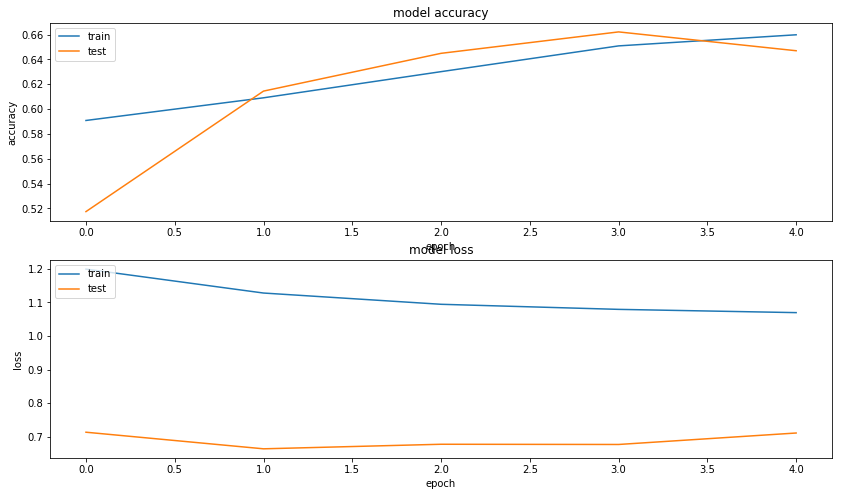

In [241]:
InteractiveShell.ast_node_interactivity = "none"

import matplotlib.pyplot as plt  
plt.rcParams["figure.figsize"]=14,8
#accuracy history
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
#loss history
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

#### End Standalone LSTM Model

...Now putting it all together as a multi-input model...

### 4.3 Rearchitect with Multi-Input Model
Using Keras Functional API¶

### Review input shapes

In [242]:
InteractiveShell.ast_node_interactivity = "all"

from keras import layers
y_train_cnn.shape
y_val_cnn.shape
y_train_rnn.shape
y_val_rnn.shape

#### Set Global Params

In [243]:
from keras.layers import Bidirectional
from keras.layers import SimpleRNN
from keras.layers import LeakyReLU


cnn_num_features = MAX_SEQUENCE_LENGTH
maxlen = cnn_num_features
timestep = 116
seq_num_features = numcols


##### Model Inputs

In [244]:
#CNN_input = Input(shape=(cnn_num_features, input_dim))
CNN_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
RNN_input = Input(shape=(timestep,seq_num_features))
CNN_input.shape
RNN_input.shape

dropoutrate = 0.5
inner_dropoutrate= 0.5

TensorShape([Dimension(None), Dimension(1500)])

TensorShape([Dimension(None), Dimension(116), Dimension(46)])

In [245]:
from keras.layers import Conv1D, MaxPooling1D, MaxPooling2D,MaxPooling3D,Embedding 

#Rebuild CNN Model Architecture with Contextual Data
embedded_sequences = embedding_layer(CNN_input)

conv = Conv1D(filters=128, kernel_size=8,activation='relu', 
              kernel_initializer='lecun_uniform')(embedded_sequences)
CNN_x = MaxPooling1D(5)(conv)
CNN_x = Dropout(inner_dropoutrate)(CNN_x)

CNN_x = Conv1D(filters=128, kernel_size=16,activation='relu', 
              kernel_initializer='lecun_uniform')(CNN_x)
CNN_x = MaxPooling1D(5)(CNN_x)  # global max pooling
CNN_x = Dropout(inner_dropoutrate)(CNN_x)

CNN_x = Conv1D(filters=128, kernel_size=16,activation='relu', 
              kernel_initializer='lecun_uniform')(CNN_x)  #lecun_uniform
CNN_x = MaxPooling1D(35)(CNN_x)  # global max pooling
CNN_x = Dropout(dropoutrate)(CNN_x)
 
CNN_x = Flatten()(CNN_x)
CNN_x = Dense(60)(CNN_x)

In [246]:
# using noisy initial state https://r2rt.com/non-zero-initial-states-for-recurrent-neural-networks.html
RNN_x = Bidirectional(layers.LSTM(132, 
                    use_bias = True, return_sequences=False ,stateful=False, kernel_initializer='VarianceScaling', 
                    recurrent_initializer='VarianceScaling', bias_initializer='VarianceScaling',
                    dropout=dropoutrate, recurrent_dropout=.4))(RNN_input)                      
             
RNN_x  = layers.LeakyReLU(alpha=0.1)(RNN_x)
RNN_x = Dense(100)(RNN_x)

##### Combine the two model inputs and add rest of architecture

In [247]:
#Concatanate Layers from each Model
concatenated_vars = layers.concatenate([CNN_x,RNN_x], axis=-1)

#Add rest of Architecture
hidden1 = layers.Dense(48, activation = 'relu')(concatenated_vars)
hidden1 = Dropout(dropoutrate)(hidden1)
output1 = layers.Dense(2, activation='sigmoid')(hidden1)

In [248]:
#Define model
model = Model([CNN_input,RNN_input], output1)  #SimpleRNN_input

In [249]:
from keras.callbacks import LambdaCallback
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: print(model.layers[0].get_weights()))
print_weights

In [384]:
#Set vaiables
class_weight = {0 :1., 1: 10}
multi_model_path = 'Multi_input_CNNandRNN_Model_Best_Run_Dec12.h5'
learning_rate = .00000000001  #9 zeroes
BATCH_SIZE = 500
BATCH_SHAPE = (BATCH_SIZE, sequence_length,numcols)

In [385]:
#define optimizers and parameters
rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0, clipnorm=.5)
adam = keras.optimizers.Adam(lr=learning_rate, clipnorm=.5, beta_1=0.9, beta_2=0.999, 
                             epsilon=None, decay=0.0, amsgrad=True)

#compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [386]:
#Display model summary
model.summary()

#save a plot of the model to file
from keras.utils import plot_model
plot_model(model, to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1500)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1500, 300)    88200       input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 1493, 128)    307328      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_13 (MaxPooling1D) (None, 298, 128)     0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
dropout_19

##### Fit mulit-input model

#### Fit the model

In [ ]:
history = model.fit([X_train_cnn,X_train_rnn],[y_train_cnn], 
                    epochs= 200, #20, 
                    batch_size=BATCH_SIZE,  
                    verbose=2, 
                    shuffle=True,
                    validation_data=([X_val_cnn,X_val_rnn],y_val_cnn),
                    class_weight = class_weight,
                    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='min'),
             keras.callbacks.ModelCheckpoint(multi_model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=1), print_weights] )

Train on 42700 samples, validate on 21498 samples
Epoch 1/200
 - 147s - loss: 0.8041 - acc: 0.8152 - val_loss: 0.6392 - val_acc: 0.7934

Epoch 00001: val_loss improved from inf to 0.63923, saving model to Multi_input_CNNandRNN_Model_Best_Run_Dec12.h5
[]
Epoch 2/200
 - 137s - loss: 0.8028 - acc: 0.8204 - val_loss: 0.6697 - val_acc: 0.7785

Epoch 00002: val_loss did not improve from 0.63923
[]
Epoch 3/200
 - 137s - loss: 0.7792 - acc: 0.8270 - val_loss: 0.6647 - val_acc: 0.7892

Epoch 00003: val_loss did not improve from 0.63923
[]
Epoch 4/200
 - 137s - loss: 0.7856 - acc: 0.8161 - val_loss: 0.6131 - val_acc: 0.7972

Epoch 00004: val_loss improved from 0.63923 to 0.61310, saving model to Multi_input_CNNandRNN_Model_Best_Run_Dec12.h5
[]
Epoch 5/200
 - 137s - loss: 0.7882 - acc: 0.8170 - val_loss: 0.6398 - val_acc: 0.8036

Epoch 00005: val_loss did not improve from 0.61310
[]
Epoch 6/200
 - 138s - loss: 0.7922 - acc: 0.8123 - val_loss: 0.6247 - val_acc: 0.7842

Epoch 00006: val_loss did no

In [ ]:
InteractiveShell.ast_node_interactivity = "none"
import matplotlib.pyplot as plt  
plt.rcParams["figure.figsize"]=10,8
#accuracy history
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
#loss history
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 

## 5: Evaluation

In [378]:
# Load the model
model = load_model( 'Multi_input_CNNandRNN_Model_Best_Run_Dec12.h5')
 



Convert y_val_rnn format toy_val_rnn_classes

    From
      array([[1., 0.],
             [0., 1.],
             [1., 0.]], dtype=float32)
    to
      array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [379]:
flag = [1]
ix = np.isin(y_val_rnn, flag)
r, c = np.where(ix)
y_val_rnn_classes = c

### Prediction by model is [prob(class=0), prob(class=1)]

In [380]:
y_pred_prob = model.predict([X_val_cnn,X_val_rnn])

### Convert probablities to class label

In [381]:
#y_pred_class = keras.np_utils.probas_to_classes(y_pred_proba)
y_pred_class = y_pred_prob.argmax(axis=-1)

### Confusiton Matrix, precision and recall

tn:  16922 
fp:  3205 
fn:  792 
tp:  579
precision:	  0.1530126849894292
recall:		  0.4223194748358862
acc:		  0.8140757279746953


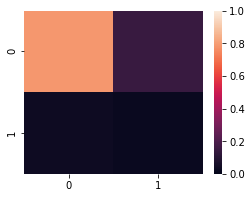

In [382]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

confusion_mat = confusion_matrix(y_val_rnn_classes, y_pred_class); confusion_mat

_ = plt.figure(figsize = (4,3))
_ = sb.heatmap(confusion_mat/confusion_mat.sum(), vmin=0, vmax=1)

tn, fp, fn, tp = confusion_mat.ravel()
print('tn: ', tn, '\nfp: ', fp, '\nfn: ', fn, '\ntp: ', tp)

precision = tp/(tp+fp); print('precision:\t ', precision)
recall = tp/(tp+fn); print('recall:\t\t ', recall)
acc = (tp+tn)/(tp+tn+fp+fn); print('acc:\t\t ', acc)

### End -  Prepped Data Frames Script